# Homework Assignment 2
**Owen Erker**

---

In [1]:
import skimage as ski
import sklearn as skl
import pydicom
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from medmnist import PneumoniaMNIST

from sklearn.decomposition import PCA

---

## 1 Measureing the Lings in a CT Scan

In [2]:
image_data = {}

for root, dirs, files in os.walk(os.getcwd()):
    for file in files:
        file_path = os.path.join(root, file)
        if file.endswith('.dcm'):
            img = pydicom.dcmread(file_path)
            image_data[file] = img.pixel_array
        elif file.endswith('.nii'):
            img = nib.load(file_path)
            image_data[file] = img.get_fdata()
        elif file.endswith('.png'): 
            img = ski.io.imread(file_path)
            image_data[file] = img

image_data.keys()

dict_keys(['coronacases_org_008.nii', '1-05.dcm', '1-10.dcm', '1-15.dcm', 'cropped_US16.nii', 'micrograph-BBBC038.png'])

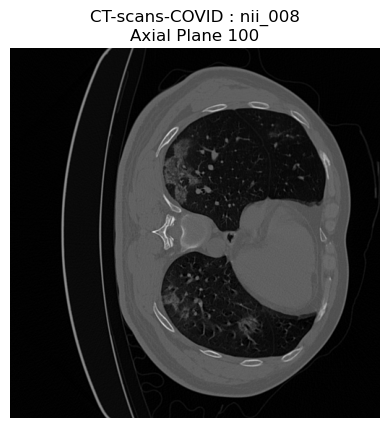

In [3]:
nii_008 = image_data['coronacases_org_008.nii']
plane_index = 100
plane_nii_008 = nii_008[:, :, plane_index]

plt.imshow(plane_nii_008, cmap='gray')
plt.title(f'CT-scans-COVID : nii_008\nAxial Plane {plane_index}')
plt.axis('off')
plt.show()

### 1.1 Procedure

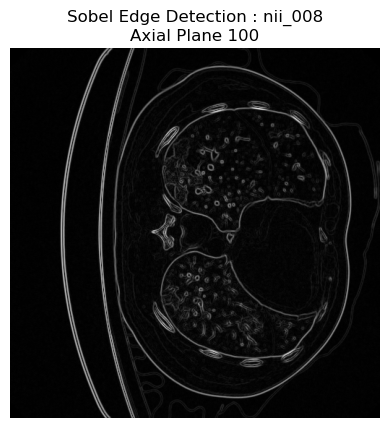

In [4]:
# Q1
sobel_nii_008 = ski.filters.sobel(plane_nii_008)

plt.imshow(sobel_nii_008, cmap='gray')
plt.title(f'Sobel Edge Detection : nii_008\nAxial Plane {plane_index}')
plt.axis('off')
plt.show()

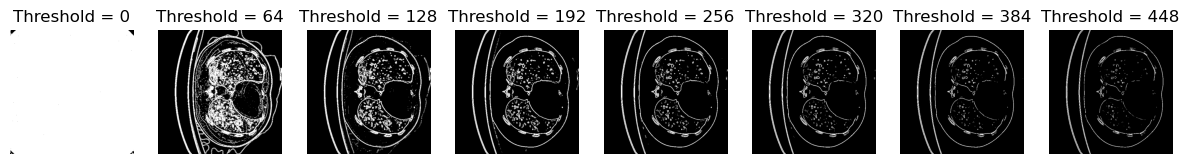

In [5]:
# Q2
threshold_values = list(range(0, 512, 64))
plt.figure(figsize=(15, 5))

for i, k in enumerate(threshold_values):
    binary_nii_008 = sobel_nii_008 > k
    plt.subplot(1, len(threshold_values), i + 1)
    plt.imshow(binary_nii_008, cmap='gray')
    plt.title(f"Threshold = {k}")
    plt.axis("off")
plt.show()

binary_nii_008 = sobel_nii_008 > 128

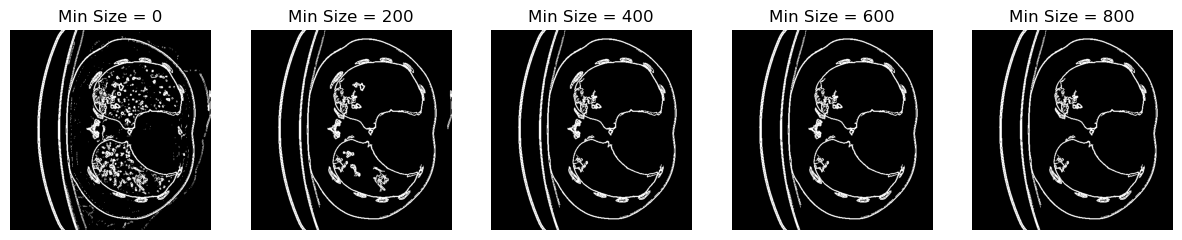

In [6]:
# Q3
min_size = list(range(0, 1000, 200))
plt.figure(figsize=(15, 5))

for i, k in enumerate(min_size):
    cleaned_nii_008 = ski.morphology.remove_small_objects(binary_nii_008, min_size=k)
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(cleaned_nii_008, cmap='gray')
    plt.title(f"Min Size = {k}")
    plt.axis("off")   
plt.show()

cleaned_nii_008 = ski.morphology.remove_small_objects(binary_nii_008, min_size=800)

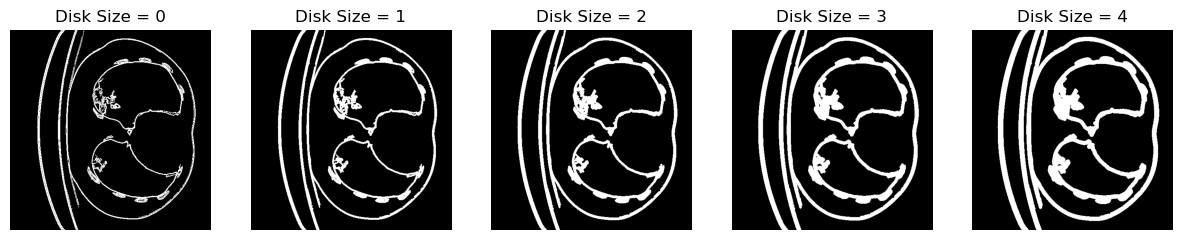

In [7]:
# Q4
disk_size = list(range(0, 5, 1))
plt.figure(figsize=(15, 5))

for i, k in enumerate(disk_size):
    dilated_nii_008 = ski.morphology.dilation(cleaned_nii_008, ski.morphology.disk(k))
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(dilated_nii_008, cmap='gray')
    plt.title(f"Disk Size = {k}")
    plt.axis("off")
plt.show()

dilated_nii_008 = ski.morphology.dilation(cleaned_nii_008, ski.morphology.disk(1))

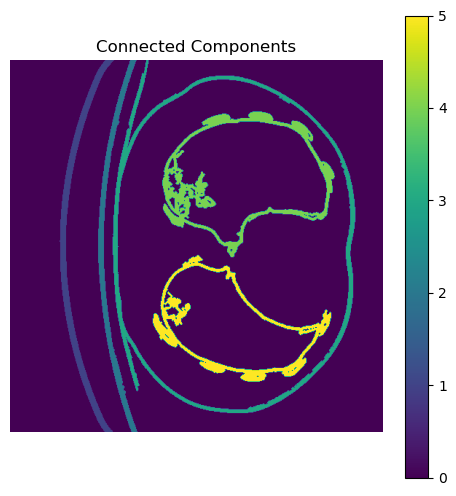

There are 5 components in the image.


In [8]:
# Q5
labeled_nii_008 = ski.morphology.label(dilated_nii_008)

plt.figure(figsize=(6, 6))
plt.imshow(labeled_nii_008)
plt.title("Connected Components")
plt.axis("off")
plt.colorbar()
plt.show()

num_components = np.max(labeled_nii_008)
print(f'There are {num_components} components in the image.')

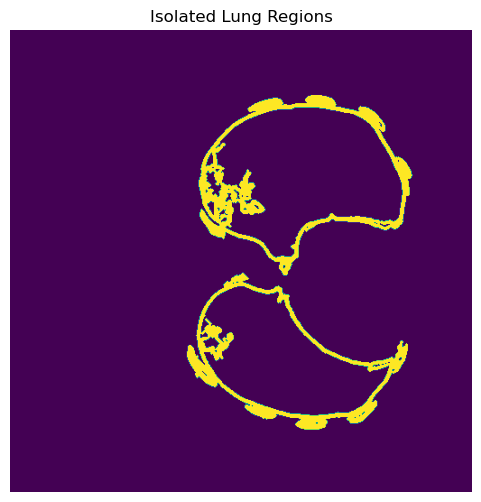

The lung component identifiers were [4, 5].
3 components were removed.


In [9]:
# Q6
lung_labels = [4, 5]
lung_nii_008 = np.isin(labeled_nii_008, lung_labels)

plt.figure(figsize=(6, 6))
plt.imshow(lung_nii_008)
plt.title("Isolated Lung Regions")
plt.axis("off")
plt.show()

num_removed = num_components - len(lung_labels)
print(f'The lung component identifiers were {lung_labels}.\n{num_removed} components were removed.')

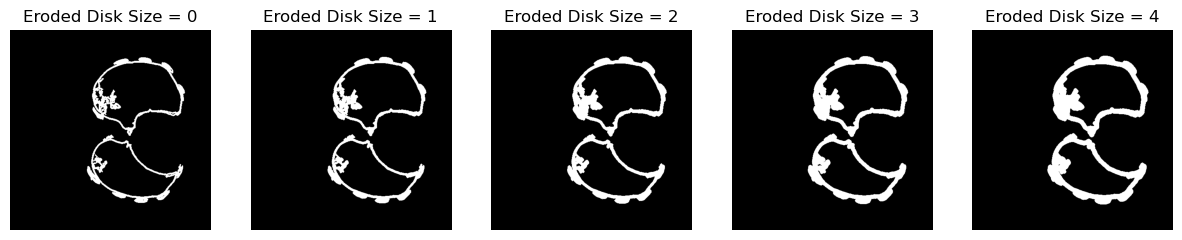

In [10]:
# Q7
binary_nii_008 = lung_nii_008.astype(np.uint8)

erosion_disk_size = min_size = list(range(0, 5, 1))
plt.figure(figsize=(15, 5))

for i, k in enumerate(erosion_disk_size):
    eroded_nii_008 = ski.morphology.dilation(binary_nii_008, ski.morphology.disk(k))
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(eroded_nii_008, cmap='gray')
    plt.title(f"Eroded Disk Size = {k}")
    plt.axis("off")
plt.show()

eroded_nii_008 = ski.morphology.dilation(binary_nii_008, ski.morphology.disk(0))

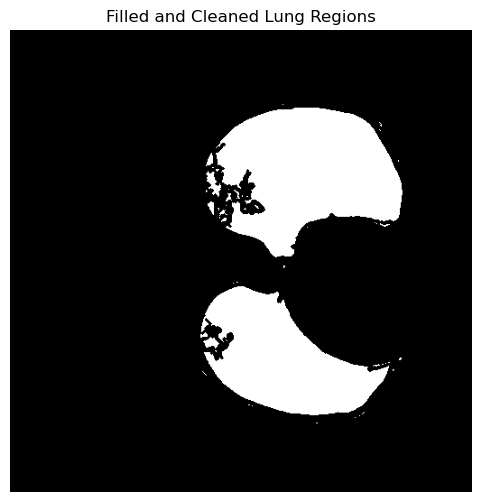

In [11]:
# Q8
filled_nii_008 = scipy.ndimage.binary_fill_holes(eroded_nii_008)

final_nii_008 = np.logical_xor(filled_nii_008, eroded_nii_008)

plt.figure(figsize=(6, 6))
plt.imshow(final_nii_008, cmap='gray')
plt.title("Filled and Cleaned Lung Regions")
plt.axis("off")
plt.show()

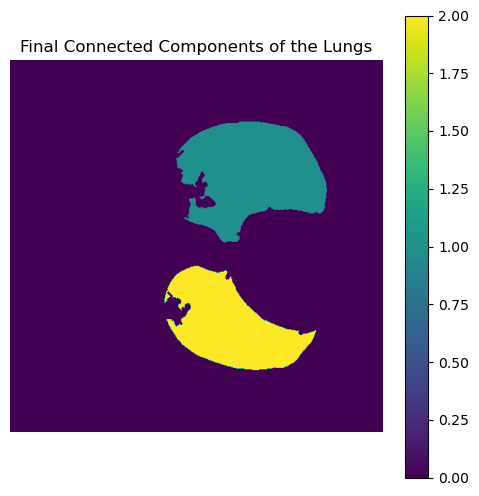

In [12]:
# Q9
final_cleaned_nii_008 = ski.morphology.remove_small_objects(final_nii_008, min_size=1000)
final_labeled_nii_008 = ski.morphology.label(final_cleaned_nii_008)

plt.figure(figsize=(6, 6))
plt.imshow(final_labeled_nii_008)
plt.title("Final Connected Components of the Lungs")
plt.axis("off")
plt.colorbar()
plt.show()

### 1.2 Measurements

In [13]:
# Q10
lung_1_size = np.sum(final_labeled_nii_008 == 1)
lung_2_size = np.sum(final_labeled_nii_008 == 2)

print(f'Approximate size of Lung 1: {lung_1_size} pixels.\nApproximate size of Lung 2: {lung_2_size} pixels.')

Approximate size of Lung 1: 22421 pixels.
Approximate size of Lung 2: 16048 pixels.


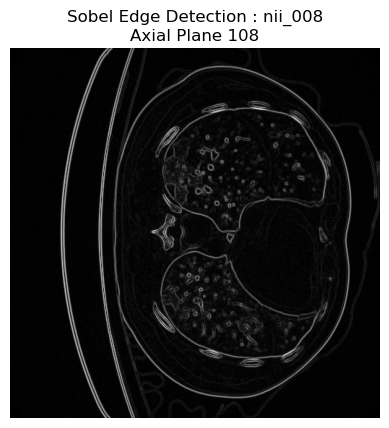

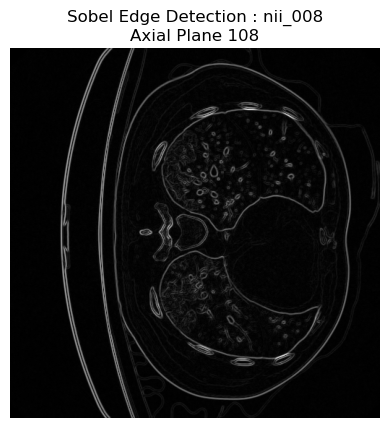

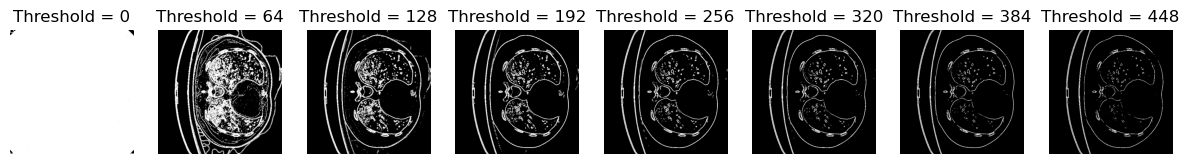

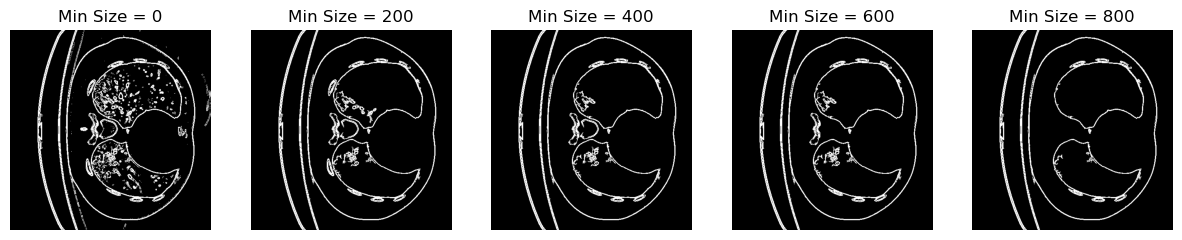

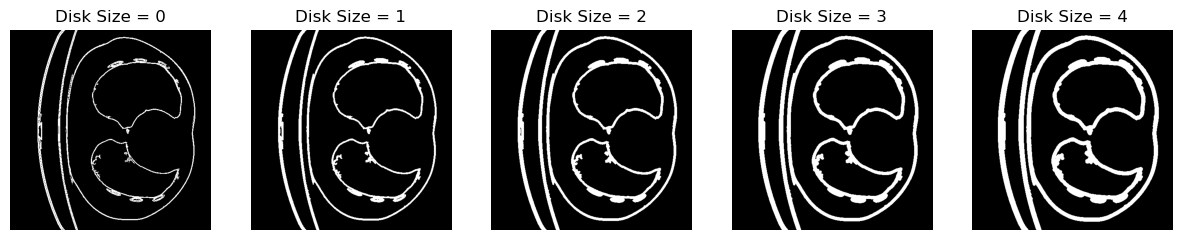

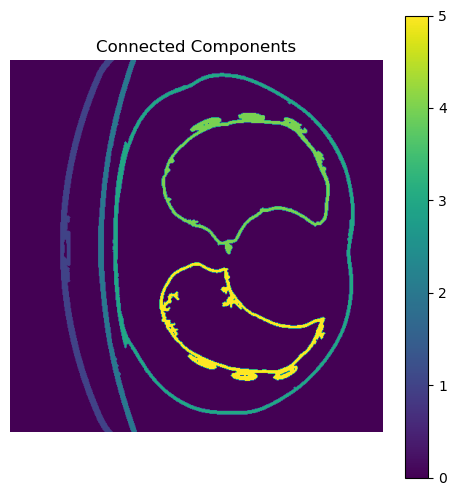

There are 5 components in the image.


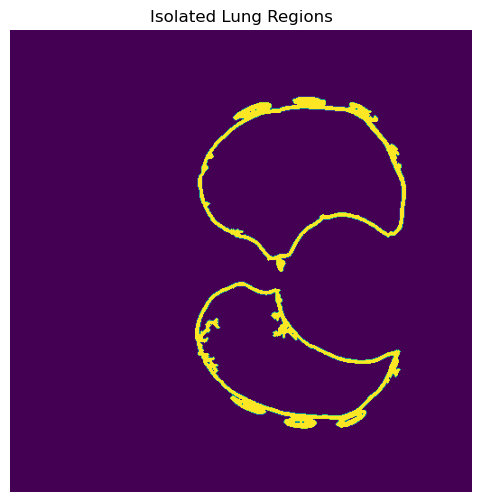

The lung component identifiers were [4, 5].
3 components were removed.


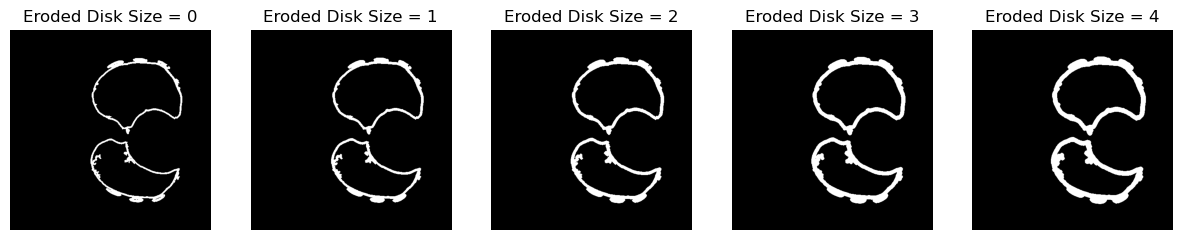

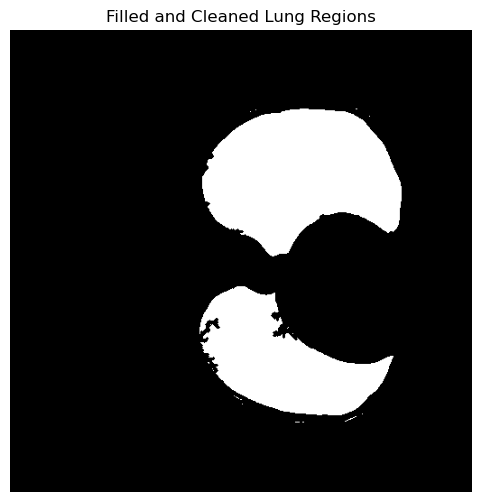

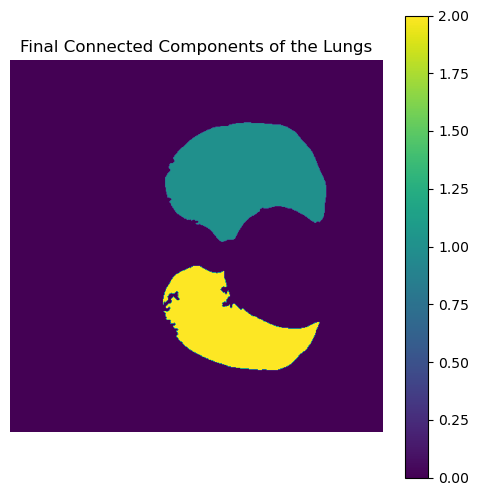

Approximate size of Lung 1: 25001 pixels.
Approximate size of Lung 2: 15934 pixels.


In [14]:
# Optional (Bonus)
plane_index = 108
plane_nii_008 = nii_008[:, :, plane_index]
plt.imshow(sobel_nii_008, cmap='gray')
plt.title(f'Sobel Edge Detection : nii_008\nAxial Plane {plane_index}')
plt.axis('off')
plt.show()

sobel_nii_008 = ski.filters.sobel(plane_nii_008)
plt.imshow(sobel_nii_008, cmap='gray')
plt.title(f'Sobel Edge Detection : nii_008\nAxial Plane {plane_index}')
plt.axis('off')
plt.show()

threshold_values = list(range(0, 512, 64))
plt.figure(figsize=(15, 5))
for i, k in enumerate(threshold_values):
    binary_nii_008 = sobel_nii_008 > k
    plt.subplot(1, len(threshold_values), i + 1)
    plt.imshow(binary_nii_008, cmap='gray')
    plt.title(f"Threshold = {k}")
    plt.axis("off")
plt.show()
binary_nii_008 = sobel_nii_008 > 160

min_size = list(range(0, 1000, 200))
plt.figure(figsize=(15, 5))
for i, k in enumerate(min_size):
    cleaned_nii_008 = ski.morphology.remove_small_objects(binary_nii_008, min_size=k)
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(cleaned_nii_008, cmap='gray')
    plt.title(f"Min Size = {k}")
    plt.axis("off")   
plt.show()

cleaned_nii_008 = ski.morphology.remove_small_objects(binary_nii_008, min_size=800)
disk_size = list(range(0, 5, 1))
plt.figure(figsize=(15, 5))
for i, k in enumerate(disk_size):
    dilated_nii_008 = ski.morphology.dilation(cleaned_nii_008, ski.morphology.disk(k))
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(dilated_nii_008, cmap='gray')
    plt.title(f"Disk Size = {k}")
    plt.axis("off")
plt.show()
dilated_nii_008 = ski.morphology.dilation(cleaned_nii_008, ski.morphology.disk(1))

labeled_nii_008 = ski.morphology.label(dilated_nii_008)
plt.figure(figsize=(6, 6))
plt.imshow(labeled_nii_008)
plt.title("Connected Components")
plt.axis("off")
plt.colorbar()
plt.show()
num_components = np.max(labeled_nii_008)
print(f'There are {num_components} components in the image.')

lung_labels = [4, 5]
lung_nii_008 = np.isin(labeled_nii_008, lung_labels)
plt.figure(figsize=(6, 6))
plt.imshow(lung_nii_008)
plt.title("Isolated Lung Regions")
plt.axis("off")
plt.show()
num_removed = num_components - len(lung_labels)
print(f'The lung component identifiers were {lung_labels}.\n{num_removed} components were removed.')

binary_nii_008 = lung_nii_008.astype(np.uint8)
erosion_disk_size = min_size = list(range(0, 5, 1))
plt.figure(figsize=(15, 5))
for i, k in enumerate(erosion_disk_size):
    eroded_nii_008 = ski.morphology.dilation(binary_nii_008, ski.morphology.disk(k))
    plt.subplot(1, len(min_size), i + 1)
    plt.imshow(eroded_nii_008, cmap='gray')
    plt.title(f"Eroded Disk Size = {k}")
    plt.axis("off")
plt.show()
eroded_nii_008 = ski.morphology.dilation(binary_nii_008, ski.morphology.disk(0))

filled_nii_008 = scipy.ndimage.binary_fill_holes(eroded_nii_008)
final_nii_008 = np.logical_xor(filled_nii_008, eroded_nii_008)
plt.figure(figsize=(6, 6))
plt.imshow(final_nii_008, cmap='gray')
plt.title("Filled and Cleaned Lung Regions")
plt.axis("off")
plt.show()

final_cleaned_nii_008 = ski.morphology.remove_small_objects(final_nii_008, min_size=1000)
final_labeled_nii_008 = ski.morphology.label(final_cleaned_nii_008)
plt.figure(figsize=(6, 6))
plt.imshow(final_labeled_nii_008)
plt.title("Final Connected Components of the Lungs")
plt.axis("off")
plt.colorbar()
plt.show()

lung_1_size = np.sum(final_labeled_nii_008 == 1)
lung_2_size = np.sum(final_labeled_nii_008 == 2)
print(f'Approximate size of Lung 1: {lung_1_size} pixels.\nApproximate size of Lung 2: {lung_2_size} pixels.')

---

## 2 Counting Cells in Microscopy Images

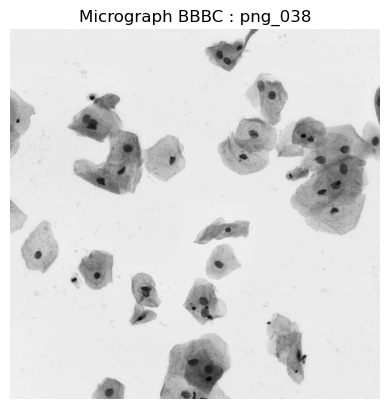

In [15]:
png_038 = image_data['micrograph-BBBC038.png']
png_038 = ski.color.rgb2gray(ski.color.rgba2rgb(png_038))

plt.imshow(png_038, cmap='grey')
plt.title(f'Micrograph BBBC : png_038')
plt.axis('off')
plt.show()

### 2.1 Procedure

**Laplacian Filter** : $I^\prime = I + \nabla^2I$

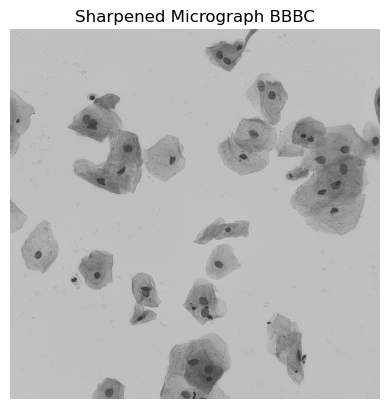

In [16]:
# Q11
sharpened_038 = png_038 + ski.filters.laplace(png_038)

plt.imshow(sharpened_038, cmap='grey')
plt.title(f'Sharpened Micrograph BBBC')
plt.axis('off')
plt.show()

In [17]:
range(0, sharpened_038.shape[0])

range(0, 1024)

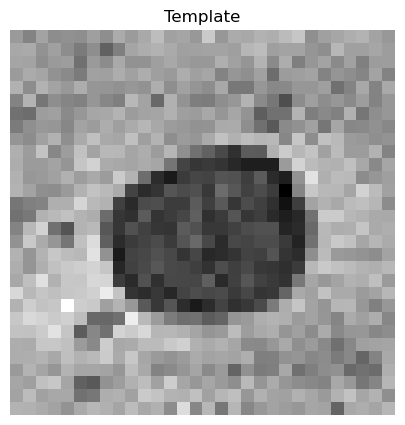

In [18]:
# Q12
x, y = 588, 540
template_size = 30
plt.figure(figsize=(15, 5))
template = sharpened_038[y:y+template_size, x:x+template_size]

plt.imshow(template, cmap='gray')
plt.title(f"Template")
plt.axis("off")
plt.show()

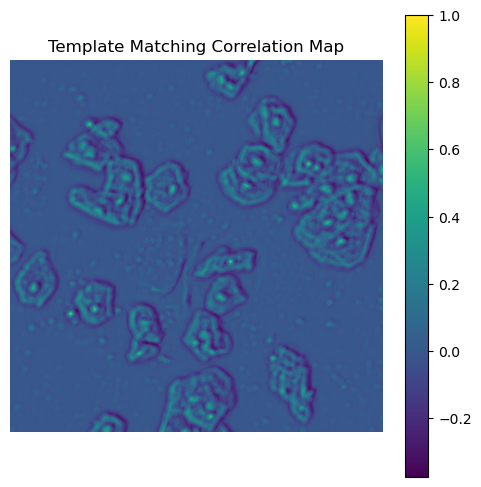

In [19]:
# Q13
correlation_038 = ski.feature.match_template(sharpened_038, template)
plt.figure(figsize=(6, 6))
plt.imshow(correlation_038, cmap="viridis")
plt.title("Template Matching Correlation Map")
plt.colorbar()
plt.axis("off")
plt.show()

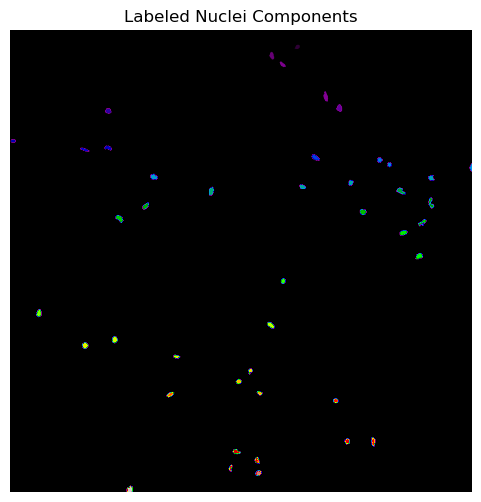

In [20]:
# Q14
threshold_value = 0.3
binary_038 = correlation_038 > threshold_value

cleaned_038 = ski.morphology.remove_small_objects(binary_038, min_size=50)

labeled_038 = ski.morphology.label(cleaned_038)

plt.figure(figsize=(6, 6))
plt.imshow(labeled_038, cmap="nipy_spectral")
plt.title("Labeled Nuclei Components")
plt.axis("off")
plt.show()

### 2.2 Measurements

In [21]:
# Q15
num_nuclei = np.max(labeled_038)

print(f'There are {num_nuclei} identified nuclei in the image')

There are 44 identified nuclei in the image


---

## 3 Analyzing a Collection of Chest X-Rays

In [22]:
dataset = PneumoniaMNIST(split="train", download=True, size=128)

### 3.1 Exploring the Dataset

In [23]:
# Q16
print(f'{dataset}\n----------\nThe binary 0 and 1 reference whether the image is normal or has pneumonia.')

Dataset PneumoniaMNIST of size 128 (pneumoniamnist_128)
    Number of datapoints: 4708
    Root location: C:\Users\odog2\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
----------
The binary 0 and 1 reference whether the image is normal or has pneumonia.


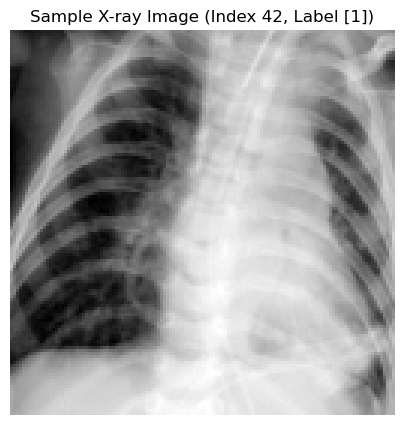

In [24]:
# Q17
x_train = dataset.imgs[:500]
y_train = np.array(dataset.labels[:500])

image_index = 42

plt.figure(figsize=(5, 5))
plt.imshow(x_train[image_index], cmap="gray")
plt.title(f"Sample X-ray Image (Index {image_index}, Label {y_train[image_index]})")
plt.axis("off")
plt.show()

In [25]:
# Q18
num_normal = np.sum(y_train == 0)
num_pneumonia = np.sum(y_train == 1)
print(f"Number of Normal Images (0): {num_normal}\nNumber of Pneumonia Images (1): {num_pneumonia}")

Number of Normal Images (0): 126
Number of Pneumonia Images (1): 374


### 3.2 Feature Extraction

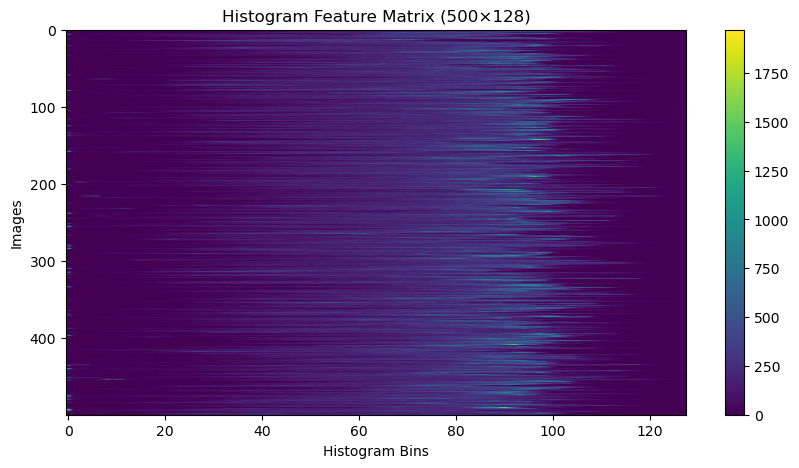

In [26]:
# Q19
num_bins = 128
hist_matrix = np.zeros((500, num_bins))

for i in range(500):
    hist, _ = np.histogram(x_train[i].ravel(), bins=num_bins, range=(0, 255))
    hist_matrix[i, :] = hist

plt.figure(figsize=(10, 5))
plt.imshow(hist_matrix, cmap="viridis", aspect='auto')
plt.title("Histogram Feature Matrix (500×128)")
plt.xlabel("Histogram Bins")
plt.ylabel("Images")
plt.colorbar()
plt.show()

**Standardization Equation** : $\hat{X} = \frac{X-\mu}{\sigma}$

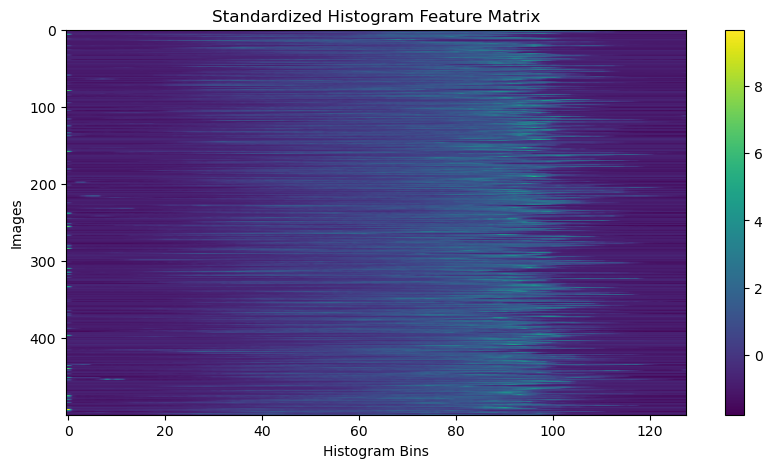

In [27]:
# Q20
mean_hist = np.mean(hist_matrix, axis=1, keepdims=True)
std_hist = np.std(hist_matrix, axis=1, keepdims=True)

std_hist[std_hist == 0] = 1

hist_matrix_std = (hist_matrix - mean_hist) / std_hist

plt.figure(figsize=(10, 5))
plt.imshow(hist_matrix_std, cmap="viridis", aspect="auto")
plt.title("Standardized Histogram Feature Matrix")
plt.xlabel("Histogram Bins")
plt.ylabel("Images")
plt.colorbar()
plt.show()

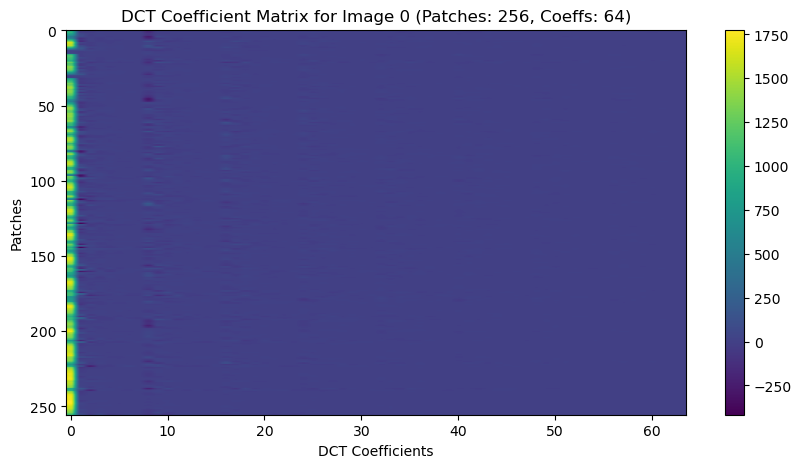

In [28]:
# Q21
def compute_dct_patches(image, patch_size=8):
    h, w = image.shape
    dct_matrix = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                dct_patch = scipy.fft.dctn(patch, norm='ortho')
                dct_matrix.append(dct_patch.flatten())
    return np.array(dct_matrix)

sample_image = x_train[0]
dct_features = compute_dct_patches(sample_image)

plt.figure(figsize=(10, 5))
plt.imshow(dct_features, cmap="viridis", aspect="auto")
plt.title(f"DCT Coefficient Matrix for Image 0 (Patches: {dct_features.shape[0]}, Coeffs: {dct_features.shape[1]})")
plt.xlabel("DCT Coefficients")
plt.ylabel("Patches")
plt.colorbar()
plt.show()

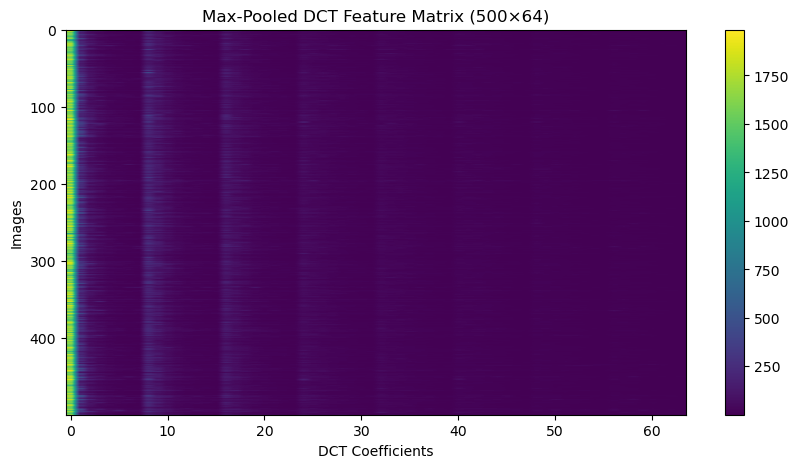

In [29]:
# Q22
dct_summary_matrix = np.zeros((500, 64))
for i in range(500):
    dct_features = compute_dct_patches(x_train[i])
    if dct_features.shape[0] > 0:
        dct_summary_matrix[i, :] = np.max(dct_features, axis=0)

plt.figure(figsize=(10, 5))
plt.imshow(dct_summary_matrix, cmap="viridis", aspect="auto")
plt.title("Max-Pooled DCT Feature Matrix (500×64)")
plt.xlabel("DCT Coefficients")
plt.ylabel("Images")
plt.colorbar()
plt.show()

### 3.3 Feature Analysis

In [30]:
# Q23
pca_hist = PCA(n_components=2)
H_pca = pca_hist.fit_transform(hist_matrix_std)
explained_variance = pca_hist.explained_variance_ratio_

print(f"Explained Variance of PC1: {explained_variance[0]:.4f}\nExplained Variance of PC2: {explained_variance[1]:.4f}\nTotal Explained Variance (PC1 + PC2): {sum(explained_variance):.4f}")

Explained Variance of PC1: 0.3734
Explained Variance of PC2: 0.1689
Total Explained Variance (PC1 + PC2): 0.5423


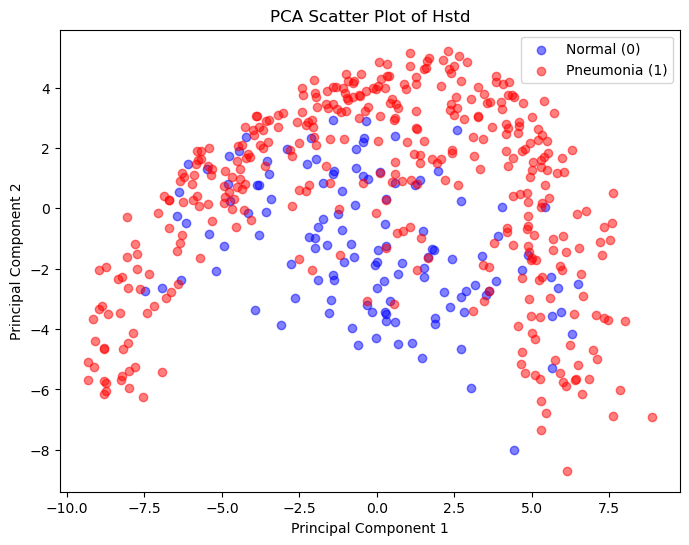

In [31]:
# Q24
hstd_scatter_fig = plt.figure(figsize=(8, 6))
plt.scatter(H_pca[y_train.flatten() == 0, 0], H_pca[y_train.flatten() == 0, 1], color="blue", label="Normal (0)", alpha=0.5)
plt.scatter(H_pca[y_train.flatten() == 1, 0], H_pca[y_train.flatten() == 1, 1], color="red", label="Pneumonia (1)", alpha=0.5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of Hstd")
plt.legend()
plt.show()

**Normalized Euclidean Distance** : $\tilde{D} = \frac{D}{\max{D}}$

In [32]:
# Q25
H_pca_0 = H_pca[y_train.flatten() == 0]
H_pca_1 = H_pca[y_train.flatten() == 1]

D_hist = scipy.spatial.distance.cdist(H_pca_0, H_pca_1, metric="euclidean")
D_hist_norm = D_hist / np.max(D_hist)

mean_distance_hist = np.mean(D_hist_norm)

print(f"Mean Normalized Distance Between Classes (Hstd): {mean_distance_hist:.4f}")

Mean Normalized Distance Between Classes (Hstd): 0.3794


Explained Variance of PC1: 0.6444
Explained Variance of PC2: 0.1674
Total Explained Variance (PC1 + PC2): 0.8118


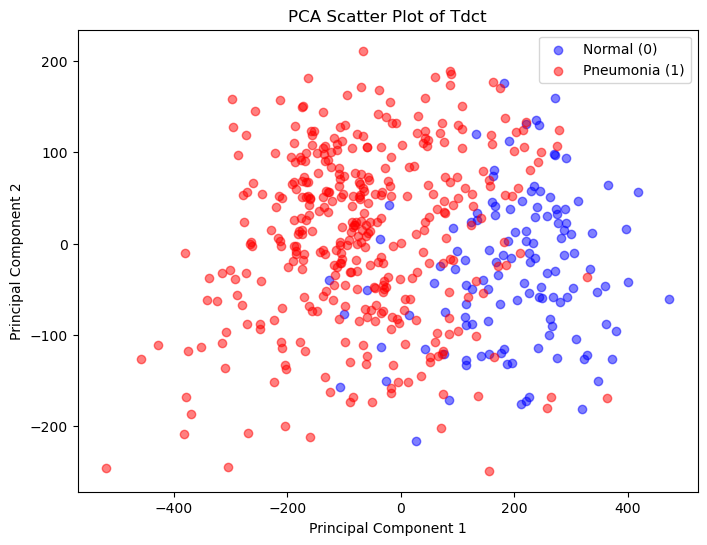

Mean Normalized Distance Between Classes (Tdct): 0.3162


In [33]:
# Q26

pca_dct = PCA(n_components=2)
T_pca = pca_dct.fit_transform(dct_summary_matrix)
explained_variance_dct = pca_dct.explained_variance_ratio_
print(f"Explained Variance of PC1: {explained_variance_dct[0]:.4f}\nExplained Variance of PC2: {explained_variance_dct[1]:.4f}\nTotal Explained Variance (PC1 + PC2): {sum(explained_variance_dct):.4f}")

tdct_scatter_fig = plt.figure(figsize=(8, 6))
plt.scatter(T_pca[y_train.flatten() == 0, 0], T_pca[y_train.flatten() == 0, 1], color="blue", label="Normal (0)", alpha=0.5)
plt.scatter(T_pca[y_train.flatten() == 1, 0], T_pca[y_train.flatten() == 1, 1], color="red", label="Pneumonia (1)", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot of Tdct")
plt.legend()
plt.show()

T_pca_0 = T_pca[y_train.flatten() == 0]
T_pca_1 = T_pca[y_train.flatten() == 1]
D_dct = scipy.spatial.distance.cdist(T_pca_0, T_pca_1, metric="euclidean")
D_dct_norm = D_dct / np.max(D_dct)
mean_distance_dct = np.mean(D_dct_norm)
print(f"Mean Normalized Distance Between Classes (Tdct): {mean_distance_dct:.4f}")

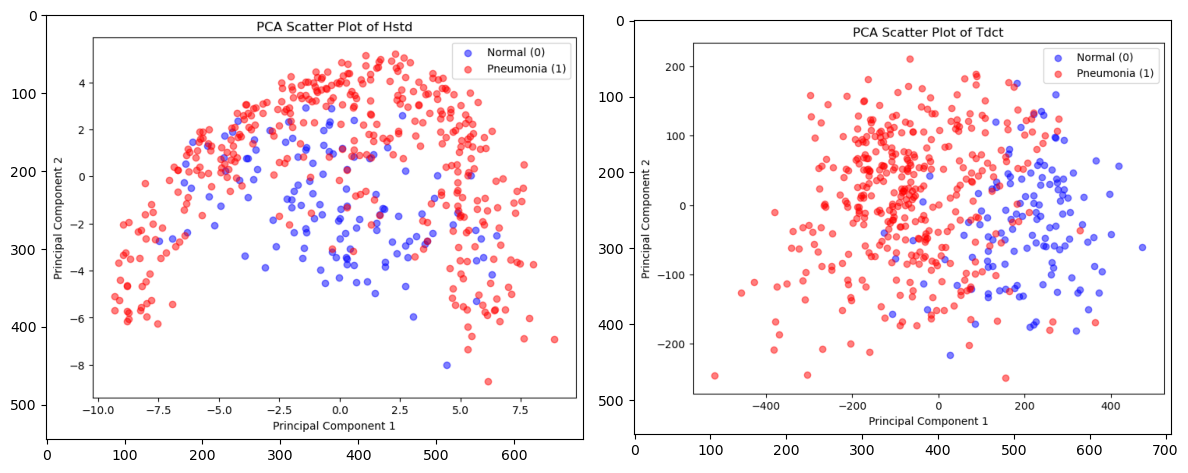

The component features of the TDCT plot appear to have a better separation of variables by a linear line between Pneumonia(1) and Normal(0) points compared to the HSTD.  However, the HSTD does show some separation, with Normal(0) being envolped by the Pneumonia(1) points.


In [34]:
# Q27
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(hstd_scatter_fig.canvas.buffer_rgba())
plt.subplot(1, 2, 2)
plt.imshow(tdct_scatter_fig.canvas.buffer_rgba())
plt.tight_layout()
plt.show()

print(f'The component features of the TDCT plot appear to have a better separation of variables by a linear line between Pneumonia(1) and Normal(0) points compared to the HSTD.  However, the HSTD does show some separation, with Normal(0) being envolped by the Pneumonia(1) points.')

In [35]:
# Q28
print(f"Mean Normalized Distance (Hstd - Histogram Features): {mean_distance_hist:.4f}\nMean Normalized Distance (Tdct - Texture Features): {mean_distance_dct:.4f}")
print(f'Histogram-based features (Hstd) provide better separation.')

Mean Normalized Distance (Hstd - Histogram Features): 0.3794
Mean Normalized Distance (Tdct - Texture Features): 0.3162
Histogram-based features (Hstd) provide better separation.
